In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
# Define parameters
DATASET_PATH = "/content/drive/MyDrive/Car parts/External"  # Update as needed
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [ ]:
# -------------------------------
# 1. Load the Dataset (70/30 split)
# -------------------------------
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.3,  # 70% for training, 30% for validation
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int"
)

Found 13882 files belonging to 4 classes.
Using 9718 files for training.


In [ ]:
class_names = ds_train.class_names
print("Class Names:", class_names)

Class Names: ['Air intake', 'Fog light', 'Headlight', 'Tail light']


In [ ]:
# Apply caching and prefetching for performance
ds_train = ds_train.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

ds_val = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.3,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int"
)
ds_val = ds_val.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 13882 files belonging to 4 classes.
Using 4164 files for validation.


In [ ]:
# -------------------------------
# 2. Compute Class Weights (if dataset is imbalanced)
# -------------------------------
labels = []
for _, y in ds_train:
    labels.extend(y.numpy())
labels = np.array(labels)
class_weights = compute_class_weight("balanced", classes=np.unique(labels), y=labels)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

In [ ]:
# -------------------------------
# 3. Data Augmentation Pipeline
# -------------------------------
# Create the augmentation pipeline once (outside mapping functions)
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2))
])

In [ ]:
# -------------------------------
# 4. Build the Model Using EfficientNetB0
# -------------------------------
# Use EfficientNetB0 as a base model for resource-efficient transfer learning
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze the base model initially

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Build the complete model using the functional API
inputs = keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)  # Apply augmentations
# Preprocess input as required by EfficientNetB0
x = tf.keras.applications.efficientnet.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)

model = keras.Model(inputs, outputs)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,214,055 (16.08 MB)

 Trainable params: 1,515,444 (5.78 MB)

 Non-trainable params: 2,698,611 (10.29 MB)

In [ ]:
# -------------------------------
# 5. Training: Two-Stage Process
# -------------------------------

# Callbacks to save resources and adjust learning rate dynamically
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]

In [ ]:
# Stage 1: Train the top (newly added) layers with the base frozen
history1 = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=10,
    class_weight=class_weights_dict,
    callbacks=callbacks
)

Epoch 1/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 4406s 15s/step - accuracy: 0.8838 - loss: 0.3352 - val_accuracy: 0.9707 - val_loss: 0.1039 - learning_rate: 0.0010
Epoch 2/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 617s 2s/step - accuracy: 0.9632 - loss: 0.1167 - val_accuracy: 0.9724 - val_loss: 0.0910 - learning_rate: 0.0010
Epoch 3/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 621s 2s/step - accuracy: 0.9710 - loss: 0.0965 - val_accuracy: 0.9760 - val_loss: 0.0872 - learning_rate: 0.0010
Epoch 4/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 615s 2s/step - accuracy: 0.9716 - loss: 0.0956 - val_accuracy: 0.9760 - val_loss: 0.0843 - learning_rate: 0.0010
Epoch 5/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 623s 2s/step - accuracy: 0.9758 - loss: 0.0803 - val_accuracy: 0.9762 - val_loss: 0.0851 - learning_rate: 0.0010
Epoch 6/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9772 - loss: 0.0672
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
304/304 ━━━━━━━━━━━━━━━━━━━━ 621s 2s/step - accuracy: 0.9772 - loss: 0.0

In [ ]:
# Stage 2: Fine-tune the top layers of the base model
base_model.trainable = True
# Optionally, freeze the lower layers to focus training on higher-level features
for layer in base_model.layers[:-20]:
    layer.trainable = False

In [ ]:
# Recompile with a lower learning rate for fine-tuning
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history2 = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=10,
    class_weight=class_weights_dict,
    callbacks=callbacks
)

Epoch 1/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 682s 2s/step - accuracy: 0.9557 - loss: 0.1453 - val_accuracy: 0.9820 - val_loss: 0.0718 - learning_rate: 1.0000e-04
Epoch 2/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 683s 2s/step - accuracy: 0.9797 - loss: 0.0671 - val_accuracy: 0.9851 - val_loss: 0.0616 - learning_rate: 1.0000e-04
Epoch 3/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 685s 2s/step - accuracy: 0.9847 - loss: 0.0547 - val_accuracy: 0.9846 - val_loss: 0.0620 - learning_rate: 1.0000e-04
Epoch 4/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 688s 2s/step - accuracy: 0.9896 - loss: 0.0367 - val_accuracy: 0.9880 - val_loss: 0.0530 - learning_rate: 1.0000e-04
Epoch 5/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 675s 2s/step - accuracy: 0.9904 - loss: 0.0336 - val_accuracy: 0.9873 - val_loss: 0.0550 - learning_rate: 1.0000e-04
Epoch 6/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9929 - loss: 0.0290
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
304/304 ━━━━━━━━━━━━━━━━━━━━ 679s 2s/step - accuracy: 

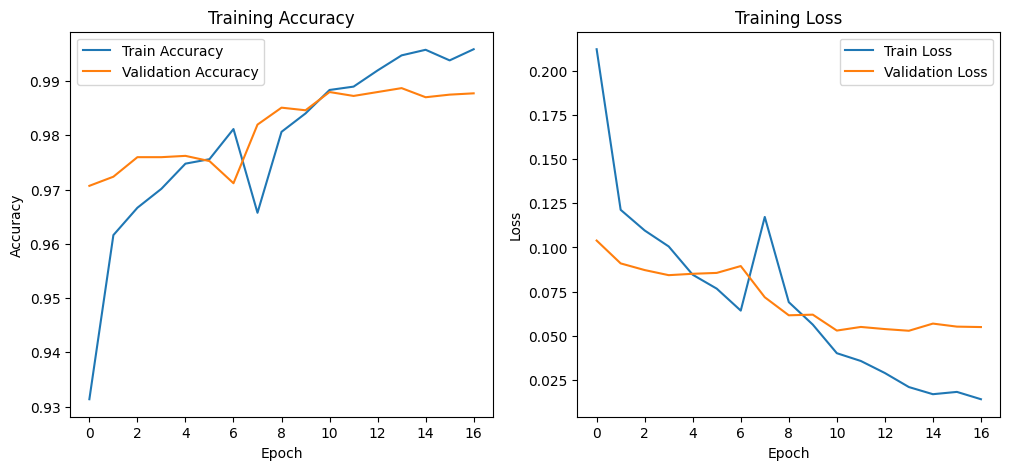

In [ ]:
# -------------------------------
# 6. Plot Training History
# -------------------------------
acc = history1.history['accuracy'] + history2.history['accuracy']
val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
loss = history1.history['loss'] + history2.history['loss']
val_loss = history1.history['val_loss'] + history2.history['val_loss']

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')
plt.show()

In [ ]:
import tensorflow as tf

# Load the model
model = tf.keras.models.load_model("/content/drive/MyDrive/School work/New_Asset.h5")

# Compile the model with metrics to address the warning
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Convert to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the converted model
with open("PartwiseB_model.tflite", "wb") as f:
    f.write(tflite_model)

print("Model successfully converted to TFLite!")

Saved artifact at '/tmp/tmpyv87mysn'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer_13')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  136736585842960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136736585844688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136736585844880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136736585843920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136736585844112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136736585846416: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model successfully converted to TFLite!
